In [1]:
import pandas as pd
import os, sys, time, glob, pickle

print("Current environment directory:" + sys.prefix)
print("System version: "+sys.version)

Current environment directory:/home/emunsing/Research/StorageLocation/env
System version: 2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]


# Collect unprocessed nodes:
This file checks the intermediate results from running the efficiencysweep on multiple cores (intermediate files are like efficiencyResults_pid3241temp.csv'), and outputs a file nodeList.pkl which contains the list of nodes which have not yet been processed.  the intermediate results from running the efficiencyResults on different cores,

In [13]:
# Use this if we want to first set the input file to be used
os.environ['INPUTFILE'] = "inputData/pricedata_LMP.csv"

In [ ]:
! echo $INPUTFILE

In [12]:
try:
    fname = os.environ['INPUTFILE']
except KeyError:
    fname = "inputData/pricedata_LMP_100.csv" # Only 100 nodes    

APNode_Prices = pd.read_csv( fname, header=0,index_col=0)#,nrows=10)
goodNodes = (APNode_Prices.isnull().sum(axis=1) < (0.02 * APNode_Prices.shape[1])) # True if node is less than x% NaN values
APNode_Prices = APNode_Prices[goodNodes]
    
allNodeNames = APNode_Prices.index.values

# Read all the dataframes, and return a dataframe from all the dataframes together
allFiles = glob.glob('Data/efficiencyResults*temp.csv')
dfList = []
for fname in allFiles:
    df = pd.read_csv(fname, index_col=0, header=0, usecols=[0,1,2,3]) # Just hold on to enough data to check whether they are completed
    dfList.append(df)
allDfs = pd.concat(dfList)

completed = allDfs.iloc[:,-1].dropna()
uniqueCompleteNodes = completed.index.unique().values
remainingNodes = list(set(allNodeNames) - set(uniqueCompleteNodes))
remainingNodes.sort()

with open('nodeList.pkl','wb') as f:
    f.write(pickle.dumps(remainingNodes))
os.environ['NODELIST'] = "TRUE"  # This will lead efficiencySweep to work from this update node list
    
print("%s nodes remaining uncompleted" %len(remainingNodes))

# End conditions: 
#  - List of Uncompleted node name strings are stored in nodeList.pkl
#  - Environment nodeList flag is set (efficiencySweep will use this next time)

#  - 

412

In [24]:
# Just check the list of unprocessed nodes
with open('nodeList.pkl','rb')as f:
    a = pickle.loads(f.read())

print("%s nodes remaining uncompleted" %len(remainingNodes))


412 nodes remaining uncompleted


#  Aggregate data for future processing/Plotting
Goal: Create the same style output as if the processes hadn't died. This is:
- `Data/kwhValue_step_02.csv`: Full results for cycleCount and storageProfit for each node at a range of efficiencies.
- `Data/powerOut_90pct.csv` : Full results for purchases/sales of all nodes at 90% efficiency for all hours in the study period

Data sizes:
- All nodes: 2247
- Good nodes: 2212 (NaN data below 2% cutoff)
- Somehow processed: 2187
- Fully complete: 1800
- Remaining: 412

There is a lot of duplication, however each node's results should be unique and repeatable. This will not be the case if we repeat 

In [137]:
allFiles = glob.glob('Data/efficiencyResults*temp.csv')
dfList = []
for fname in allFiles:
    df = pd.read_csv(fname, index_col=[0,1], header=0) # Just hold on to enough data to check whether they are completed
    dfList.append(df)
allDfs = pd.concat(dfList)
allDfs.sort_index(inplace=True)

results = allDfs.dropna().drop_duplicates()  #Empirically, dropping duplicate rows should produce unique entries for each node.

profitDf = results.loc[(slice(None),'storageProfit'),:].reset_index(level=1,drop=True)
cycleDf  = results.loc[(slice(None),'cycleCount'),:].reset_index(level=1,drop=True)

profitDf.to_csv('Data/kwhValueAggregated_step_02.csv')
cycleDf.to_csv('Data/cycleCountAggregated_step_02.csv')


In [ ]:
powerResults.to_csv('Data/powerOutput_90pct.csv')

In [139]:
temp = pd.read_csv('Data/kwhValue_step_02.csv')
temp.head()

,Unnamed: 0,0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.54,0.56,...,0.82,0.84,0.86,0.88,0.9,0.92,0.94,0.96,0.98,1.0
0,BCRK1-2_1_N004,0.009496,0.012697,0.017382,0.024001,0.032685,0.042400,0.054986,0.071549,0.089914,...,0.417614,0.448102,0.478983,0.511859,0.546199,0.581289,0.617696,0.657998,0.702779,0.759007
1,BCRK4_7_B3,0.009471,0.012442,0.017085,0.023646,0.032241,0.041887,0.053850,0.070296,0.088525,...,0.413125,0.443479,0.474222,0.506948,0.541157,0.576124,0.612418,0.653187,0.698056,0.754136
2,BELLOTA_2_B1,0.005967,0.007969,0.010841,0.016422,0.024330,0.033382,0.045461,0.061143,0.079205,...,0.382696,0.408945,0.437867,0.470005,0.504325,0.540738,0.579249,0.621858,0.676051,0.747159
3,BELLPGE_1_N001,0.005602,0.007540,0.010006,0.014789,0.021987,0.031058,0.040865,0.055266,0.072348,...,0.376964,0.404902,0.435292,0.469014,0.504392,0.541299,0.580648,0.622403,0.676209,0.745996
4,BELRIDGE_1_N001,0.006034,0.008065,0.011412,0.016971,0.024063,0.032621,0.042147,0.056796,0.074412,...,0.378244,0.405511,0.434989,0.466354,0.499859,0.534997,0.571568,0.610865,0.655586,0.714053


In [140]:
import matplotlib.pyplot as plt
% matplotlib inline

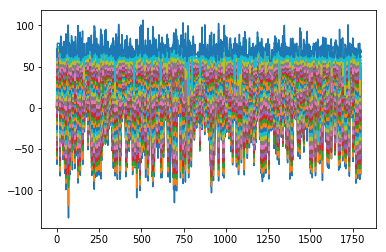

In [142]:
plt.plot(profitDf.values)

In [134]:
complete = allDfs.dropna()
complete = complete.drop_duplicates()

In [135]:
complete.shape

(3600, 31)

In [120]:
uniqueCompleteNodes.values.shape

(1800,)

In [121]:
duplicateNodes = list(set(completeNotUnique) - set(uniqueCompleteNodes))

In [125]:
len(set(completeNotUnique))

1800

In [131]:
allDfs.loc[('ADCC_2_N001',slice(None)),:]

0.4        0.42        0.44        0.46  \
            Unnamed: 1                                                      
ADCC_2_N001 cycleCount     338.999961  415.999970  496.999976  617.999975   
            cycleCount     338.999961  415.999970  496.999976  617.999975   
            storageProfit    3.175630    3.738461    4.404686    5.189198   
            storageProfit    3.175630    3.738461    4.404686    5.189198   

                                 0.48         0.5        0.52         0.54  \
            Unnamed: 1                                                       
ADCC_2_N001 cycleCount     738.999979  860.999989  984.999993  1134.999995   
            cycleCount     738.999979  860.999989  984.999993  1134.999995   
            storageProfit    6.135430    7.221153    8.441563     9.805214   
            storageProfit    6.135430    7.221153    8.441563     9.805214   

                                  0.56         0.58     ...              0.82  \
            Unnamed: 1                                  ...                     
ADCC_2_N001 cycleCount     1279.999998  1421.999998     ...       2429.988023   
            cycleCount     1279.999998  1421.999998     ...       2429.988023   
            storageProfit    11.326596    12.973464     ...         37.572672   
            storageProfit    11.326596    12.973464     ...         37.572672   

                                  0.84         0.86         0.88          0.9  \
            Unnamed: 1                                                          
ADCC_2_N001 cycleCount     2520.000000  2641.965713  2780.000000  2921.978141   
            cycleCount     2520.000000  2641.965713  2780.000000  2921.978141   
            storageProfit    39.755294    41.973799    44.250495    46.586581   
            storageProfit    39.755294    41.973799    44.250495    46.586581   

                                  0.92         0.94         0.96         0.98  \
            Unnamed: 1                                                          
ADCC_2_N001 cycleCount     3099.978609  3388.958114  3815.856406  4576.919596   
            cycleCount     3099.978609  3388.958114  3815.856406  4576.919596   
            storageProfit    48.997996    51.525790    54.257878    57.335680   
            storageProfit    48.997996    51.525790    54.257878    57.335680   

                                   1.0  
            Unnamed: 1                  
ADCC_2_N001 cycleCount     6429.779426  
            cycleCount     6429.779426  
            storageProfit    61.120148  
            storageProfit    61.120148  

[4 rows x 31 columns]

In [130]:
tempDf = pd.DataFrame(zip(*completeNotUnique)).transpose()
tempDf.head()

,0,1
0,ACTONSC_6_N001,storageProfit
1,ADCC_2_N001,storageProfit
2,ADCC_2_N001,storageProfit
3,AEC300_1_N001,storageProfit
4,AGNEW_1_N003,storageProfit


In [64]:
justProfit = completed.loc[:,:]

SyntaxError: invalid syntax (<ipython-input-64-a00d51fed2ba>, line 1)

In [42]:
uniqueCompleteNodes.shape

(3600,)

In [50]:
temp = allDfs.loc[uniqueCompleteNodes,:]
temp.shape

(7660, 31)

In [48]:
completed.head()

             Unnamed: 1   
LAKE_2_N034  cycleCount       6775.046531
             storageProfit      64.710068
LAKE_2_N035  cycleCount       6775.046532
             storageProfit      64.710068
LAKE_2_N403  cycleCount       6776.427278
Name: 1.0, dtype: float64

In [47]:
uniqueCompleteNodes[0:10]

array([('LAKE_2_N034', 'cycleCount'), ('LAKE_2_N034', 'storageProfit'),
       ('LAKE_2_N035', 'cycleCount'), ('LAKE_2_N035', 'storageProfit'),
       ('LAKE_2_N403', 'cycleCount'), ('LAKE_2_N403', 'storageProfit'),
       ('COLNGA2_6_N001', 'cycleCount'),
       ('COLNGA2_6_N001', 'storageProfit'), ('PALA_6_N001', 'cycleCount'),
       ('PALA_6_N001', 'storageProfit')], dtype=object)

In [33]:
temp = "Data/powerOut_90pct.csv"
df = pd.read_csv(fname, index_col=[0,1],header=0)
df.head()

,,2012-01-01 09:00:00+00:00,2012-01-01 10:00:00+00:00,2012-01-01 11:00:00+00:00,2012-01-01 12:00:00+00:00,2012-01-01 13:00:00+00:00,2012-01-01 14:00:00+00:00,2012-01-01 15:00:00+00:00,2012-01-01 16:00:00+00:00,2012-01-01 17:00:00+00:00,2012-01-01 18:00:00+00:00,...,2016-12-31 22:00:00+00:00,2016-12-31 23:00:00+00:00,2017-01-01 00:00:00+00:00,2017-01-01 01:00:00+00:00,2017-01-01 02:00:00+00:00,2017-01-01 03:00:00+00:00,2017-01-01 04:00:00+00:00,2017-01-01 05:00:00+00:00,2017-01-01 06:00:00+00:00,2017-01-01 07:00:00+00:00
,2012-01-01 08:00:00+00:00,,,,,,,,,,,,,,,,,,,,,
LAKE_2_N034,0.0,0.000000e+00,1.000000e-12,1.054093,1.000000e-12,2.466535e-11,1.530533e-09,0.0,0.0,-9.486833e-01,2.466535e-11,...,-1.001032e-13,-1.001032e-13,-1.001032e-13,-0.948683,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13
LAKE_2_N035,0.0,0.000000e+00,1.000000e-12,1.054093,1.000000e-12,1.000000e-12,1.897346e-12,0.0,0.0,-9.486833e-01,2.846050e-12,...,-1.001032e-13,-1.001032e-13,-1.001032e-13,-0.948683,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13
LAKE_2_N403,0.0,0.000000e+00,1.000000e-12,1.054093,1.000000e-12,2.371668e-11,1.073908e-09,0.0,0.0,-9.486833e-01,2.371668e-11,...,-1.001032e-13,-1.001032e-13,-1.001032e-13,-0.948683,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13
COLNGA2_6_N001,0.0,0.000000e+00,1.000000e-12,1.054093,1.000000e-12,0.000000e+00,0.000000e+00,0.0,0.0,-9.486833e-01,1.000000e-12,...,-1.001032e-13,-1.001032e-13,-1.001032e-13,-0.948683,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13
PALA_6_N001,0.0,-1.000000e-12,1.000000e-12,1.054093,1.000000e-12,0.000000e+00,9.780798e-11,0.0,0.0,-4.174114e-11,6.640657e-12,...,1.054093e+00,2.133656e-14,-1.001032e-13,-0.948683,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13


In [30]:
fname = 'Data/efficiencyResults_pid32418temp.csv'
df = pd.read_csv(fname, index_col=[0,1], header=0)
df.head()

0.4        0.42        0.44        0.46  \
            Unnamed: 1                                                      
LAKE_2_N034 cycleCount     357.000000  431.000000  523.999995  630.999992   
            storageProfit    4.942195    5.565646    6.304056    7.155861   
LAKE_2_N035 cycleCount     356.999958  430.999962  523.999971  630.999982   
            storageProfit    4.942213    5.565669    6.304063    7.155870   
LAKE_2_N403 cycleCount     357.000000  431.000000  524.000000  630.999998   

                                 0.48         0.5        0.52         0.54  \
            Unnamed: 1                                                       
LAKE_2_N034 cycleCount     746.999988  875.999982  995.999970  1132.999972   
            storageProfit    8.147630    9.284318   10.551996    11.942248   
LAKE_2_N035 cycleCount     746.999986  875.999987  995.999989  1132.999995   
            storageProfit    8.147637    9.284326   10.552004    11.942256   
LAKE_2_N403 cycleCount     746.999995  875.999988  995.999977  1132.999980   

                                  0.56         0.58     ...              0.82  \
            Unnamed: 1                                  ...                     
LAKE_2_N034 cycleCount     1286.999967  1407.999961     ...       2437.999974   
            storageProfit    13.488506    15.146066     ...         39.800572   
LAKE_2_N035 cycleCount     1286.999996  1407.999997     ...       2438.000000   
            storageProfit    13.488514    15.146074     ...         39.800575   
LAKE_2_N403 cycleCount     1286.999972  1407.999967     ...       2437.999976   

                                  0.84         0.86         0.88          0.9  \
            Unnamed: 1                                                          
LAKE_2_N034 cycleCount     2541.999977  2680.999980  2834.011543  3019.022976   
            storageProfit    42.014628    44.274831    46.605046    49.022230   
LAKE_2_N035 cycleCount     2542.000000  2681.977142  2835.955306  3019.978141   
            storageProfit    42.014631    44.274833    46.605043    49.022224   
LAKE_2_N403 cycleCount     2541.999978  2680.999980  2834.011544  3018.999984   

                                  0.92         0.94         0.96         0.98  \
            Unnamed: 1                                                          
LAKE_2_N034 cycleCount     3241.034283  3599.999990  4130.999993  5006.010361   
            storageProfit    51.550563    54.236300    57.184508    60.554415   
LAKE_2_N035 cycleCount     3242.967914  3602.926700  4137.866663  5011.929646   
            storageProfit    51.550550    54.236306    57.184467    60.554392   
LAKE_2_N403 cycleCount     3240.999988  3601.010801  4130.999993  5005.999999   

                                   1.0  
            Unnamed: 1                  
LAKE_2_N034 cycleCount     6775.046531  
            storageProfit    64.710068  
LAKE_2_N035 cycleCount     6775.046532  
            storageProfit    64.710068  
LAKE_2_N403 cycleCount     6776.427278  

[5 rows x 31 columns]

In [31]:
fname = 'Data/efficiencyPower_pid32418temp.csv'
df = pd.read_csv(fname, index_col=[0,1], header=0)
df.head()

,,2012-01-01 09:00:00+00:00,2012-01-01 10:00:00+00:00,2012-01-01 11:00:00+00:00,2012-01-01 12:00:00+00:00,2012-01-01 13:00:00+00:00,2012-01-01 14:00:00+00:00,2012-01-01 15:00:00+00:00,2012-01-01 16:00:00+00:00,2012-01-01 17:00:00+00:00,2012-01-01 18:00:00+00:00,...,2016-12-31 22:00:00+00:00,2016-12-31 23:00:00+00:00,2017-01-01 00:00:00+00:00,2017-01-01 01:00:00+00:00,2017-01-01 02:00:00+00:00,2017-01-01 03:00:00+00:00,2017-01-01 04:00:00+00:00,2017-01-01 05:00:00+00:00,2017-01-01 06:00:00+00:00,2017-01-01 07:00:00+00:00
,2012-01-01 08:00:00+00:00,,,,,,,,,,,,,,,,,,,,,
LAKE_2_N034,0.0,0.000000e+00,1.000000e-12,1.054093,1.000000e-12,2.466535e-11,1.530533e-09,0.0,0.0,-9.486833e-01,2.466535e-11,...,-1.001032e-13,-1.001032e-13,-1.001032e-13,-0.948683,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13
LAKE_2_N035,0.0,0.000000e+00,1.000000e-12,1.054093,1.000000e-12,1.000000e-12,1.897346e-12,0.0,0.0,-9.486833e-01,2.846050e-12,...,-1.001032e-13,-1.001032e-13,-1.001032e-13,-0.948683,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13
LAKE_2_N403,0.0,0.000000e+00,1.000000e-12,1.054093,1.000000e-12,2.371668e-11,1.073908e-09,0.0,0.0,-9.486833e-01,2.371668e-11,...,-1.001032e-13,-1.001032e-13,-1.001032e-13,-0.948683,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13
COLNGA2_6_N001,0.0,0.000000e+00,1.000000e-12,1.054093,1.000000e-12,0.000000e+00,0.000000e+00,0.0,0.0,-9.486833e-01,1.000000e-12,...,-1.001032e-13,-1.001032e-13,-1.001032e-13,-0.948683,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13
PALA_6_N001,0.0,-1.000000e-12,1.000000e-12,1.054093,1.000000e-12,0.000000e+00,9.780798e-11,0.0,0.0,-4.174114e-11,6.640657e-12,...,1.054093e+00,2.133656e-14,-1.001032e-13,-0.948683,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13,-1.000000e-13


In [ ]:
allFiles = glob.glob('Data/efficiencyResults*temp.csv')
dfList = []
for fname in allFiles:
    df = pd.read_csv(fname, index_col=0, header=0, usecols=[0,1,2,3]) # Just hold on to enough data to check whether they are completed
    dfList.append(df)
allDfs = pd.concat(dfList)

completed = allDfs.iloc[:,-1].dropna()
uniqueCompleteNodes = completed.index.unique().values